In [1]:
from qiskit import *
from qiskit.circuit.library import *
from qiskit.quantum_info import *
import numpy as np
from scipy.linalg import *
from sympy import *

from functools import reduce

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from numpy.testing import assert_almost_equal as aae

In [2]:
tensor = lambda matrix_list: reduce(np.kron, matrix_list)

In [3]:
def one_qubit_partial_trace(rho: np.ndarray, traced_qubit: int) -> DensityMatrix:

    dim = int(np.log2(len(rho)))
    assert traced_qubit < dim, "Traced qubit index out of range"
    
    I = np.identity(2)
    zero = np.array([[1], [0]])
    one = np.array([[0], [1]])

    # Create pre and post of partial trace
    pre_zero = tensor([zero.T if i == traced_qubit else I for i in range(dim)])
    post_zero = tensor([zero if i == traced_qubit else I for i in range(dim)])
    pre_one = tensor([one.T if i == traced_qubit else I for i in range(dim)])
    post_one = tensor([one if i == traced_qubit else I for i in range(dim)])

    reduced_density_matrix = DensityMatrix(pre_zero@rho@post_zero + pre_one@rho@post_one)
    
    assert reduced_density_matrix.is_valid(), 'Reduced density operator is not valid'

    return reduced_density_matrix

def is_pure_state(rho: DensityMatrix):
    if np.isclose(np.abs(rho.purity()), 1): 
        print("Pure State")
        return rho.to_statevector().data
    else:
        print("Mixed State")
        return None

### Two-Qubit State

We know that the canonical form for any two qubit states is 

$$|\psi\rangle = \cos(\theta)|00\rangle + \sin(\theta)|11\rangle$$

This gives us the density matrix (abbreviating cosines and sines)

$$\rho_{AB} = |\psi\rangle\langle\psi| = c^2|00\rangle\langle 00|+ cs |00\rangle \langle 11| + cs |11\rangle\langle00| + s^2 |11\rangle\langle11|$$

Taking the partial trace of the subsytem $B$, we get

$$\begin{align}\rho_A = Tr_B [\rho_{AB}] &= (I\otimes \langle0|)\rho_{AB}(I\otimes |0\rangle) + (I\otimes \langle1|)\rho_{AB}(I\otimes |1\rangle) \\ &= c^2|00\rangle\langle00| + s^2|11\rangle\langle11|\end{align}$$

This gives us an expression for purity

$$\begin{align}Tr[\rho_A^2] &= \cos^4(\theta) + \sin^4(\theta) \\ &= \frac{1}{4} \cos(4\theta) + \frac{3}{4}\end{align}$$

Up to local unitary, we have

$$|\psi'\rangle = \cos(\theta)|\alpha\beta\rangle + \sin(\theta)|\alpha_{\perp} \beta_{\perp}\rangle $$

Recall that the partial trace and purity calculation is independent of subsystem basis. So now, since our state $|\psi\rangle$ and $|\psi'\rangle$ are equivalent up to local unitary, it should have the same partial trace and purity.

Our canonical form is parameterized by an angle $\theta$ and has a period of $2\pi$. Our purity expression on the other hand, has a period of $\frac{\pi}{2}$. One would think that $|\psi(\theta)\rangle \stackrel{LU}{\equiv}|\psi(\theta')\rangle$ would implies $\theta = \theta'$. This is true in certain cases, for example, $\theta' = \theta + \frac{\pi n}{2}$. This is related to the fact that a Pauli $Y$ can commute through a CX gate into Pauli $Z$ and Pauli $X$. However, when $\theta' = -\theta + \frac{\pi n}{2}$, the equivalence relation does not hold. For each purity value, there are up to 8 possibles angle values on the interval of $[-\pi, \pi]$.

Text(0, 0.5, 'Purity')

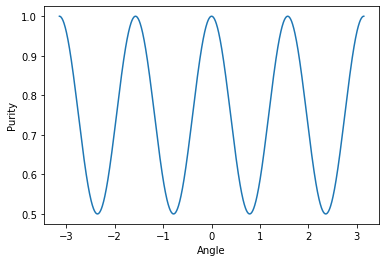

In [62]:
mu_list = []

for theta in np.linspace(-np.pi, np.pi, 1000):

    circ = QuantumCircuit(2)
    circ.ry(2*theta, 0)
    circ.cx(0, 1)
    circ.unitary(random_unitary(2), 0)
    circ.unitary(random_unitary(2), 1)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 0

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu = dm.purity()
    mu_list.append(mu)

plt.plot(np.linspace(-np.pi, np.pi, 1000), mu_list)
plt.xlabel('Angle')
plt.ylabel('Purity')

### Three Qubit

We will concern ourselves with Class 2 and Class 3 states. We can check that our states are in these two classes by taking 3 partial trace of subsystems $A, B, C$ and verifying that the corresponding reduced density matrix represents a mixed state.

#### Class 2

We will first look at the Class 2 states to analyze their entanglement structure. Below we show a representative circuit.

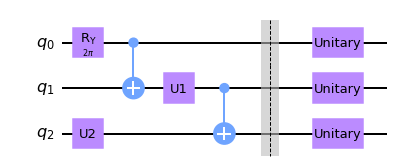

In [80]:
circ = QuantumCircuit(3)
circ.ry(2*theta, 0)
circ.cx(0, 1)
circ.unitary(random_unitary(dims = 2, seed = 1), 1, label = 'U1')
circ.unitary(random_unitary(dims = 2, seed = 2), 2, label = 'U2')
circ.cx(1, 2)

circ.barrier()
circ.unitary(random_unitary(dims = 2, seed = 0), 0)
circ.unitary(random_unitary(dims = 2, seed = 3), 1)
circ.unitary(random_unitary(dims = 2, seed = 4), 2)

circ.draw('mpl')

In fact, when we take the partial trace of a subsystem, we can ignore the layer of local unitary. We first start with tracing out qubit 0

Text(0, 0.5, 'Purity')

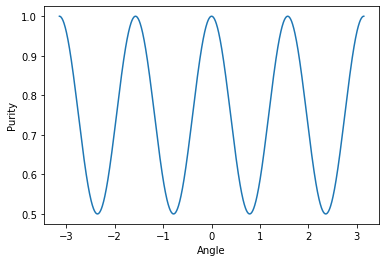

In [75]:
mu_list = []

for theta in np.linspace(-np.pi, np.pi, 1000):

    circ = QuantumCircuit(3)
    circ.ry(2*theta, 0)
    circ.cx(0, 1)
    circ.unitary(random_unitary(dims = 2, seed = np.random.randint(0, 1000)), 1)
    circ.unitary(random_unitary(dims = 2, seed = np.random.randint(0, 1000)), 2)
    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 0

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu = dm.purity()

    mu_list.append(mu)

plt.plot(np.linspace(-np.pi, np.pi, 1000), mu_list)
plt.xlabel('Angle')
plt.ylabel('Purity')

We see that the purity graph still depends on the angle of $\theta$ as the two qubit case. Variations in the parameters of $U1$ and $U2$ does not affect the purity.

Text(0, 0.5, 'Purity')

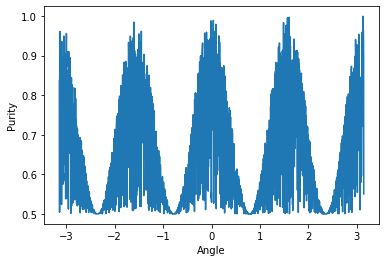

In [94]:
mu_list = []

for theta in np.linspace(-np.pi, np.pi, 2000):

    circ = QuantumCircuit(3)
    circ.ry(2*theta, 0)
    circ.cx(0, 1)
    circ.unitary(random_unitary(dims = 2, seed = np.random.randint(0, 1000) ), 1) # U1
    circ.unitary(random_unitary(dims = 2, seed = np.random.randint(0, 1000)), 2) # U2
    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 1

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu = dm.purity()

    mu_list.append(mu)

plt.plot(np.linspace(-np.pi, np.pi, 2000), mu_list)
plt.xlabel('Angle')
plt.ylabel('Purity')

The graph still has the original periodic structure that depends on $\theta$ that is it retains the period and range. However, now the amplitude of the function depends on the parameters of $U1$ and $U2$. (Investigate this!)

Text(0, 0.5, 'Purity')

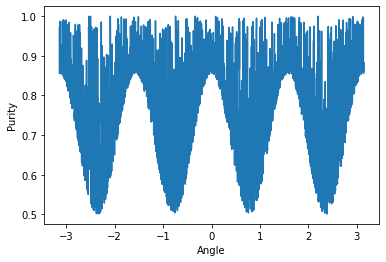

In [102]:
mu_list = []

for theta in np.linspace(-np.pi, np.pi, 2000):

    circ = QuantumCircuit(3)
    circ.ry(2*theta, 0)
    circ.cx(0, 1)
    circ.unitary(random_unitary(dims = 2, seed = 2 ), 1) # U1
    circ.unitary(random_unitary(dims = 2, seed = np.random.randint(0, 1000) ), 2) # U2
    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 2

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu = dm.purity()

    mu_list.append(mu)

plt.plot(np.linspace(-np.pi, np.pi, 2000), mu_list)
plt.xlabel('Angle')
plt.ylabel('Purity')

When both parameters of $U1$ and $U2$ are randomized. The graph lost all it sinusoidal characteristic. However, it still retains the range of the angle. Interestingly, when the parameter of $U1$ are free to range, the graph fills the bottom of the curve. On the other hand, when the parameters of $U2$ are randomized. The graph fills the top fo the curve.